In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, LayerNormalization, Dropout, Concatenate, MultiHeadAttention, GlobalAveragePooling1D
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
cohesive_data = np.load("cohesive_data_small.npy", allow_pickle=True)
mismatched_data = np.load("mismatched_data_small.npy", allow_pickle=True)

# Prepare dataset
def prepare_data(data, max_seq_len=None):
    audio_features, video_features, labels = [], [], []
    for entry in data:
        audio_features.append(entry['audio'])
        video_features.append(entry['video'].reshape(entry['video'].shape[0], -1))  # Flatten last two dims
        labels.append(entry['phoneme'])

    # Determine max sequence length if not provided
    if max_seq_len is None:
        max_seq_len = max(max(len(a) for a in audio_features), max(len(v) for v in video_features))

    # Pad sequences
    audio_features = pad_sequences(audio_features, maxlen=max_seq_len, padding='post', dtype='float32')
    video_features = pad_sequences(video_features, maxlen=max_seq_len, padding='post', dtype='float32')

    return (
        tf.convert_to_tensor(audio_features, dtype=tf.float32),
        tf.convert_to_tensor(video_features, dtype=tf.float32),
        labels,
    )

# Prepare cohesive and mismatched data
audio_train, video_train, labels_train = prepare_data(cohesive_data)
audio_test, video_test, labels_test = prepare_data(mismatched_data, max_seq_len=audio_train.shape[1])

# Encode labels
unique_labels = sorted(set(labels_train))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
labels_train_encoded = tf.convert_to_tensor([label_to_index[label] for label in labels_train], dtype=tf.int32)
labels_train_onehot = tf.one_hot(labels_train_encoded, depth=len(unique_labels))
labels_test_encoded = tf.convert_to_tensor(
    [label_to_index.get(label, -1) for label in labels_test if label in label_to_index], dtype=tf.int32
)
labels_test_onehot = tf.one_hot(labels_test_encoded, depth=len(unique_labels))

# Define Transformer Encoder Block
def transformer_encoder(inputs, num_heads, key_dim, ff_dim, dropout_rate):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)

    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dense(inputs.shape[-1], activation='relu')(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = LayerNormalization(epsilon=1e-6)(ff_output + attention_output)
    return ff_output

# Define Multimodal Transformer Model
def build_mm_transformer(input_audio_shape, input_video_shape, num_classes, num_heads=4, key_dim=64, ff_dim=128, dropout_rate=0.2):
    # Audio input and self-attention encoder
    audio_input = Input(shape=input_audio_shape, name="Audio_Input")
    audio_encoded = transformer_encoder(audio_input, num_heads, key_dim, ff_dim, dropout_rate)
    audio_pooled = GlobalAveragePooling1D()(audio_encoded)

    # Video input and self-attention encoder
    video_input = Input(shape=input_video_shape, name="Video_Input")
    video_encoded = transformer_encoder(video_input, num_heads, key_dim, ff_dim, dropout_rate)
    video_pooled = GlobalAveragePooling1D()(video_encoded)

    # Concatenate pooled outputs
    fused = Concatenate()([audio_pooled, video_pooled])
    fused = Dense(128, activation='relu')(fused)
    fused = Dropout(0.2)(fused)
    output = Dense(num_classes, activation='softmax')(fused)

    # Build the model
    model = Model(inputs=[audio_input, video_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build the model
input_audio_shape = audio_train.shape[1:]  # Exclude batch size
input_video_shape = video_train.shape[1:]  # Exclude batch size
num_classes = len(unique_labels)

model = build_mm_transformer(input_audio_shape, input_video_shape, num_classes)

# Train the model
history = model.fit(
    [audio_train, video_train],
    labels_train_onehot,
    epochs=10,
    batch_size=16,
    validation_split=0.2
)



Epoch 1/10
40/40 [==============================] - 5s 66ms/step - loss: 1.0849 - accuracy: 0.5891 - val_loss: 0.7851 - val_accuracy: 0.7688
Epoch 2/10
40/40 [==============================] - 2s 56ms/step - loss: 0.7454 - accuracy: 0.7328 - val_loss: 0.7062 - val_accuracy: 0.7750
Epoch 3/10
40/40 [==============================] - 2s 56ms/step - loss: 0.6460 - accuracy: 0.7672 - val_loss: 0.6688 - val_accuracy: 0.8062
Epoch 4/10
40/40 [==============================] - 2s 56ms/step - loss: 0.5699 - accuracy: 0.7937 - val_loss: 0.6450 - val_accuracy: 0.7750
Epoch 5/10
40/40 [==============================] - 2s 56ms/step - loss: 0.5866 - accuracy: 0.7719 - val_loss: 0.6471 - val_accuracy: 0.8062
Epoch 6/10
40/40 [==============================] - 2s 56ms/step - loss: 0.5563 - accuracy: 0.7875 - val_loss: 0.6264 - val_accuracy: 0.7812
Epoch 7/10
40/40 [==============================] - 2s 56ms/step - loss: 0.5408 - accuracy: 0.8031 - val_loss: 0.6974 - val_accuracy: 0.8188
Epoch 8/10
40

In [6]:
print("Checking for NaN or inf in audio_test:", tf.reduce_any(tf.math.is_nan(audio_test)), tf.reduce_any(tf.math.is_inf(audio_test)))
print("Checking for NaN or inf in video_test:", tf.reduce_any(tf.math.is_nan(video_test)), tf.reduce_any(tf.math.is_inf(video_test)))


Checking for NaN or inf in audio_test: tf.Tensor(False, shape=(), dtype=bool) tf.Tensor(False, shape=(), dtype=bool)
Checking for NaN or inf in video_test: tf.Tensor(False, shape=(), dtype=bool) tf.Tensor(False, shape=(), dtype=bool)


In [7]:
print(f"Audio Test Shape: {audio_test.shape}")
print(f"Video Test Shape: {video_test.shape}")
print(f"Labels Test Onehot Shape: {labels_test_onehot.shape}")


Audio Test Shape: (799, 514, 6)
Video Test Shape: (799, 514, 80)
Labels Test Onehot Shape: (0, 5)


In [8]:
# Map mismatched labels to extract both audio and video components
def extract_audio_visual_labels(label):
    """Extract audio and visual components from mismatched label."""
    visual_component = label.split("_")[0].replace("Visual-", "")
    audio_component = label.split("_")[1].replace("Audio-", "")
    return visual_component, audio_component

# Prepare mismatched dataset for testing
audio_test, video_test, labels_test = prepare_data(mismatched_data, max_seq_len=audio_train.shape[1])
visual_labels, audio_labels = zip(*[extract_audio_visual_labels(label) for label in labels_test])

# Evaluate mismatched dataset
predictions = model.predict([audio_test, video_test], verbose=2)

# Convert predictions to label indices
predicted_indices = tf.argmax(predictions, axis=1).numpy()
predicted_labels = [unique_labels[idx] for idx in predicted_indices]

# Analyze results
results = []
for i, (predicted, visual, audio) in enumerate(zip(predicted_labels, visual_labels, audio_labels)):
    results.append({
        "Sample": i,
        "Predicted": predicted,
        "Visual_Label": visual,
        "Audio_Label": audio,
        "Fused?": predicted not in [visual, audio],
    })



25/25 - 1s - 1s/epoch - 55ms/step


In [9]:
# Convert results to DataFrame for better analysis
import pandas as pd
results_df = pd.DataFrame(results)

print(results_df)


     Sample Predicted Visual_Label Audio_Label  Fused?
0         0      blue          bin        blue   False
1         1      blue         blue          at   False
2         2        at           at           f   False
3         3       two            f         two   False
4         4       two          two         bin   False
..      ...       ...          ...         ...     ...
794     794      blue         blue        blue   False
795     795       bin         blue        blue    True
796     796       bin         blue        blue    True
797     797      blue         blue         two   False
798     798       two          two        blue   False

[799 rows x 5 columns]


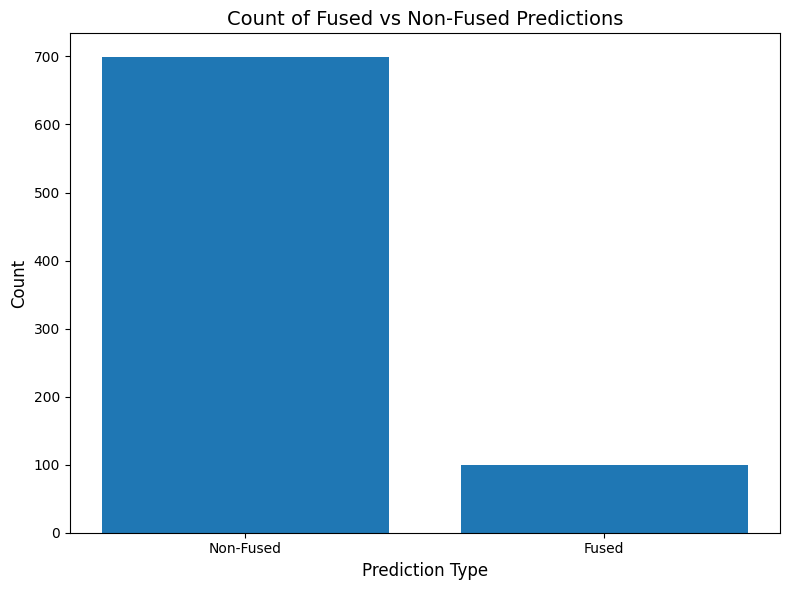

In [10]:


# Convert results to a DataFrame for easier manipulation
results_df = pd.DataFrame(results)

# Count fused and non-fused predictions
fused_counts = results_df['Fused?'].value_counts()

# Generate a bar plot
plt.figure(figsize=(8, 6))
plt.bar(['Non-Fused', 'Fused'], [fused_counts.get(False, 0), fused_counts.get(True, 0)])
plt.xlabel('Prediction Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Count of Fused vs Non-Fused Predictions', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Display the graph
plt.tight_layout()
plt.show()
